## Calculate the effect of the scene graph solver

the scene nodes are ordered, so the edge difference can be directly used to measure the difference between naively pick
the most probable edge or taking the whole graph into consideration

In [30]:
%load_ext autoreload
%autoreload 2

In [31]:
from utils import *
import networkx as nx
import matplotlib.pyplot as plt
import h5py


In [ ]:
scenes_edge = read_json('G:/My Drive/Research/data/scenes/scenes_with_rels.json')
scenes_graph = read_json('G:/My Drive/Research/data/scenes/scenes_with_rels_corrected.json')


In [ ]:
directions = ['left', 'right', 'behind', 'front']
differences = {i: {'more': [], 'few': []} for i in range(len(scenes_graph['scenes']))}

for i, (scene_graph, scene_edge) in enumerate(zip(scenes_edge['scenes'], scenes_graph['scenes'])):
    for dire in directions:
        for source, (targets_graph, targets_edge) in enumerate(zip(scene_graph['relationships'][dire],
                                                                   scene_edge['relationships'][dire])):
            targets_graph = set(targets_graph)
            targets_edge = set(targets_edge)

            more = [(source, target, dire) for target in targets_graph.difference(targets_edge)]
            few = [(source, target, dire) for target in targets_edge.difference(targets_graph)]
            differences[i]['more'].extend(more)
            differences[i]['few'].extend(few)

differences = {key : value for (key, value) in differences.items() if len(value['more']) > 0 or len(value['few']) > 0}



In [ ]:
for scene_id in differences.keys():
    print(scene_id)
    for direction in directions:
        graph = convert_to_nx(scenes_edge['scenes'][scene_id], [direction], ['r'])
        print(f'{direction} {list(nx.simple_cycles(graph))}')

In [ ]:
    # pos = nx.circular_layout(graph)
    # edges = graph.edges()
    #
    # colors = []
    # for u, v, data in list(graph.edges(data=True)):
    #     colors.append(data['color'])

# Fault Case Analysis

In [ ]:
vocab = read_json('G:/My Drive/Research/data/vocab.json')
clevr_results = read_json('G:/My Drive/Research/data/reason/results/result_clevr.json')
clevr_rel_corrected_results = read_json('G:/My Drive/Research/data/reason/results/result_clevr_corrected.json')
questions = read_json('G:/My Drive/Research/data/Original/CLEVR_questions.json')['questions']
h5_filename = 'G:/My Drive/Research/data/Original/images.h5'
images = h5py.File(h5_filename, 'r')['images']

In [ ]:
wrong_ans_indexes = [i for (i, correct) in enumerate(clevr_results['corrects']) if not correct]
wrong_ans_indexes_rel_corrected = [i for (i, correct) in enumerate(clevr_rel_corrected_results['corrects']) if not correct]


In [ ]:
i = 6696
print(i)
print(questions[i]['question'])
print(scenes_graph['scenes'][questions[i]['image_index']])
print(len(scenes_graph['scenes'][questions[i]['image_index']]['objects']))
plt.imshow(images[questions[i]['image_index']])
print(f"Model Answer: {clevr_rel_corrected_results['answers'][i]}")
print(f"Actual Result: {questions[i]['answer']}")
[vocab['program_idx_to_token'][str(i)] for i in clevr_results['programs'][i]]

## Check If the faults are repairable
1. The correct answer is ranked second, after the prediction
2. The correct answer is higher than all other objects in the scene without that property

In [ ]:
import pandas as pd

In [ ]:
error_df = pd.read_csv('G:/My Drive/Research/data/measurements/error_cases.csv')
scenes = read_json('G:/My Drive/Research/data/scenes/scenes_proba.json')['scenes']
attr_map = read_json('G:/My Drive/Research/data/clevr_attr_map.json')['attributes']
attributes = ['size', 'color', 'material', 'shape']

In [ ]:
for _, row in error_df.iterrows():
    print(row['image_id'])
    scene = scenes[row['image_id']]
    attr_name = row['attr_name']
    objects = scene['objects']

    target_obj = find_matching_object(row['detected_object'], objects, attr_map, attributes)
    if not target_obj:
        print('did not find matching object')
        continue

    print(row['attr_name'])
    actual_idx = attr_map[attr_name].index(row['actual'])
    actual_proba = target_obj[attr_name][actual_idx]
    sorted_dist = np.argsort(target_obj[attr_name])
    print(f'gt prob? {target_obj[attr_name][actual_idx]}')
    print(f'gt is the second best? {sorted_dist[-2] == actual_idx}')

    more_significant = is_more_significant(target_obj, objects, attr_name, actual_idx)
    print(f'gt is more significant? {more_significant}')


In [ ]:
error_df

# Graph Edit Distance metrics

In [ ]:
from scene_graph_transformer import get_concrete_scene_graph, get_simple_concrete_attributes
from utils import dag_constraint, anti_symmetry_constraint, construct_adj, process_gt_scenes, process_coord_scene, process_coord_scene_clevr
from tqdm import tqdm

In [ ]:
scenes = read_json('../results/clevr_block_val/constraint_1234/rel_scenes.json')['scenes']
gt_scenes = read_json(f'../data/clevr_block/constraint_1234/scenes_test.json')['scenes']
schema = read_json(f'../data/clevr_block/clevr_attr_map.json')
con_scenes = read_json('../results/clevr_block_val/constraint_1234/rel_scenes_fix.json')['scenes']
coord_scenes = read_json('../results/clevr_block_val/constraint_1234/scenes_coord_prob.json')['scenes']

In [ ]:
concrete_scenes = [get_concrete_scene_graph(scene, schema) for scene in scenes]
gt_scenes = [process_gt_scenes(scene, schema) for scene in gt_scenes]
coord_scenes = [process_coord_scene(scene, schema) for scene in coord_scenes]
for scene in coord_scenes:
    scene['objects'] = get_simple_concrete_attributes(scene, schema)

In [ ]:
concrete_error_maps = error_classification_for_scenes(concrete_scenes, gt_scenes, schema['relations'])
consistent_error_maps = error_classification_for_scenes(con_scenes, gt_scenes, schema['relations'])
coord_error_maps = error_classification_for_scenes(coord_scenes, gt_scenes, schema['relations'])

In [ ]:
from datasets.Blockworld import *

keys = ['SGGen', 'SGGen+', 'SA', 'FSA']
constraints = [SmallObjectConstraint('small'), LargeCubeConstraint('large'), BottomConstraint('bottom'), YellowObjectConstraint('yellow')]

In [ ]:
error_maps = consistent_error_maps
check_scenes = con_scenes

for key in keys:
    print(key, np.mean([m[key] for m in error_maps]))

errors = [sum([constraint.evaluate(scene) for constraint in constraints]) for scene in check_scenes]
print('CV', len([e for e in errors if e == 0]) / len(errors))

## Blocksworld

In [ ]:
from datasets.Blockworld import *
from measurements import ProblemDomain


In [ ]:
keys = ['SGGen', 'SGGen+', 'SA', 'FSA']
constraints = [SmallObjectConstraint('c1'), LargeCubeConstraint('c2'), BottomConstraint('c3'), YellowObjectConstraint('c4')]
coord_scene_transformer = process_coord_scene
blocksworld_clevr = ProblemDomain(constraints, keys, '../data/clevr_block/constraint_1234_test', '../results/clevr_block_val/original/constraint_1234/', f'../data/clevr_block/clevr_attr_map.json')
blocksworld_c3 = ProblemDomain(constraints, keys, '../data/clevr_block/c3', '../results/clevr_block_val/original/c3/', f'../data/clevr_block/clevr_attr_map.json')
blocksworld_c4 = ProblemDomain(constraints, keys, '../data/clevr_block/c4', '../results/clevr_block_val/original/c4/', f'../data/clevr_block/clevr_attr_map.json')


domains = [blocksworld_clevr, blocksworld_c3, blocksworld_c4]

In [ ]:
for domain in domains:
    domain.load_predicted_scenes(coord_scene_transformer)
    domain.cal_matrics_statistics()

In [ ]:
metrics = ['SGGen', 'SGGen+', 'SA', 'Con']
result = []

for domain in domains:
    for metric in metrics:
        result.append(np.mean(domain.coord_scene_fixed_stats[metric]))
result


## Clevr

In [ ]:
scenes = read_json('../results/clevr_val/constraint_1234/rel_scenes.json')['scenes']
gt_scenes = read_json(f'../data/clevr/constraint_1234_test/scenes.json')['scenes']
schema = read_json(f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
con_scenes = read_json('../results/clevr_val/constraint_1234/rel_scenes_fix_coord.json')['scenes']
coord_scenes = read_json('../results/clevr_val/constraint_1234/scenes_coord_prob.json')['scenes']

In [ ]:
from measurements import ProblemDomain
from datasets.Clevr import *

keys = ['SGGen', 'SGGen+', 'SA', 'FSA']
constraints =  [SameColorConstraint('c1'), MaterialConstraint('c2'), LargeCubeConstraint('c3'), PairBehindConstraint('c4')]#, ObjectIdentityConstraint('identity')]
coord_scene_transformer = process_coord_scene_clevr

clevr_full = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
clevr_half = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_50', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
clevr_quarter = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_25', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')

# domains ={
#     'clevr': clevr_full,
#     # 'c3': clevr_c3,
#     # 'c4': clevr_c4
# }
domains = [clevr_full, clevr_half, clevr_quarter]

In [ ]:
for domain in domains:
    domain.load_predicted_scenes(coord_scene_transformer, coord_scenes_fname=None, coord_fixed_fname=None)
    domain.cal_matrics_statistics()

In [ ]:
[np.mean(stats.scene_stats['SA']) for stats in domains]

In [ ]:
np.mean(clevr_c1234.scene_fixed_stats['Con'])

In [ ]:
for domain in domains.values():
    domain.load_predicted_scenes(coord_scene_transformer)
    domain.cal_matrics_statistics()

In [ ]:
metric = 'c4'
compares = [clevr_c1234.scene_stats, clevr_c1234.scene_fixed_stats, clevr_c1234.coord_scene_stats, clevr_c1234.coord_scene_fixed_stats]

print([sum(compare[metric]) for compare in compares])
print([np.mean(compare['Con']) for compare in compares])

In [177]:
import numpy as np

def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

In [ ]:
domains['clevr'].scene_fixed_stats['SA']

In [ ]:
domains['c3'].scene_fixed_stats['SA']

In [ ]:
metric = 'CV'
print(cohen_d(domains['clevr'].scene_stats[metric], domains['c3'].scene_stats[metric]))
print(cohen_d(domains['clevr'].scene_fixed_stats[metric], domains['c3'].scene_fixed_stats[metric]))
print(cohen_d(domains['clevr'].coord_scene_stats[metric], domains['c3'].coord_scene_stats[metric]))
print(cohen_d(domains['clevr'].coord_scene_fixed_stats[metric], domains['c3'].coord_scene_fixed_stats[metric]))

In [ ]:
clevr_c1234 = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
clevr_c3 = ProblemDomain(constraints, keys, '../data/clevr/c3', '../results/clevr_val/original/c3/', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
clevr_c4 = ProblemDomain(constraints, keys, '../data/clevr/c4', '../results/clevr_val/original/c4/', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')

domains_original ={
    'clevr': clevr_c1234,
    'c3': clevr_c3,
    'c4': clevr_c4
}

In [ ]:
domains_original['clevr'].load_predicted_scenes(coord_scene_transformer)
domains_original['clevr'].cal_matrics_statistics()

In [ ]:
for domain in domains_original.values():
    domain.load_predicted_scenes(coord_scene_transformer)
    domain.cal_matrics_statistics()

In [ ]:
error_map = domains_original['c3'].coord_scene_fixed_stats

print(np.mean(error_map['SGGen']))
print(np.mean(error_map['SGGen+']))
print(np.mean(error_map['SA']))
print(np.mean(error_map['FSA']))
print(np.mean(error_map['CV']))

In [ ]:
metric = 'SGGen+'
print(cohen_d(domains_original['clevr'].scene_stats[metric], domains_original['c4'].scene_stats[metric]))
print(cohen_d(domains_original['clevr'].scene_fixed_stats[metric], domains_original['c4'].scene_fixed_stats[metric]))
print(cohen_d(domains_original['clevr'].coord_scene_stats[metric], domains_original['c4'].coord_scene_stats[metric]))
print(cohen_d(domains_original['clevr'].coord_scene_fixed_stats[metric], domains_original['c4'].coord_scene_fixed_stats[metric]))

In [ ]:
domains_original['c4'].gt_scenes[1224]

# RQ1, 2

## Clevr

In [34]:
from measurements import ProblemDomain
from datasets.Clevr import *

In [176]:
def print_stats(results1, results2, metrics, setups, mapping):
    values = []
    for setup in setups:
        stats1 = mapping(results1[setup])
        stats2 = mapping(results2[setup])
        for metric in metrics:
            values.append(cohen_d(stats1[metric], stats2[metric]))
    return np.array(values)

def process_results(results, process_coord):
    for _, value in results.items():
        value.load_predicted_scenes(process_coord, coord_fixed_fname=None, fixed_scenes_fname=None)
        value.cal_matrics_statistics()

In [191]:
constraints =  [SameColorConstraint('c1'), MaterialConstraint('c2'), LargeCubeConstraint('c3'), PairBehindConstraint('c4')]
keys = ['SGGen', 'SGGen+', 'SA', 'FSA']

constrained_path = '../results/clevr_val/constraint_1234'
original_path = '../results/clevr_val/original'
test_paths = ['../data/clevr/constraint_1234_test', '../data/clevr/c3', '../data/clevr/c4']
setup_paths = ['constraint_1234', 'c3', 'c4']
schema_path = 'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json'

constrained_results_clevr = {}
original_results_clevr = {}

for i, setup in enumerate(setup_paths):
    constrained_result = ProblemDomain(constraints, keys, test_paths[i], f'{constrained_path}/{setup}', schema_path)
    original_result = ProblemDomain(constraints, keys, test_paths[i], f'{original_path}/{setup}', schema_path)
    constrained_results_clevr[setup] = constrained_result
    original_results_clevr[setup] = original_result

In [192]:
process_results(constrained_results_clevr, process_coord_scene_clevr)
process_results(original_results_clevr, process_coord_scene_clevr)

../results/clevr_val/constraint_1234/constraint_1234\rel_scenes.json


100%|██████████| 2000/2000 [00:21<00:00, 93.94it/s] 


../results/clevr_val/constraint_1234/c3\rel_scenes.json


100%|██████████| 2000/2000 [00:30<00:00, 64.89it/s]


../results/clevr_val/constraint_1234/c4\rel_scenes.json


100%|██████████| 2000/2000 [00:17<00:00, 112.96it/s]


../results/clevr_val/original/constraint_1234\rel_scenes.json


100%|██████████| 2000/2000 [00:21<00:00, 95.04it/s] 


../results/clevr_val/original/c3\rel_scenes.json


100%|██████████| 2000/2000 [00:30<00:00, 64.78it/s]


../results/clevr_val/original/c4\rel_scenes.json


100%|██████████| 2000/2000 [00:17<00:00, 113.14it/s]


In [ ]:
print_metrics(constrained_results_clevr, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats)

In [ ]:
print_metrics(original_results_clevr, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats)

In [ ]:
print_metrics(constrained_results_clevr, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats)

In [ ]:
print_metrics(original_results_clevr, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats)

In [195]:
np.array2string(print_stats(constrained_results_clevr, original_results_clevr, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats), precision=4)

'[-1.6961 -1.6726 -2.0254 -0.339  -2.522  -1.4659 -3.4665 -0.3795 -2.5191\n -1.4704 -2.0883 -0.5529]'

In [196]:
np.array2string(print_stats(constrained_results_clevr, original_results_clevr, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats), precision=4)

'[-1.0097 -0.8144 -1.1455  0.     -1.8223 -0.9488 -1.7029  0.3721 -1.6253\n -1.8284 -1.7227 -1.1649]'

In [ ]:
constrained_results['constraint_1234'].load_predicted_scenes(process_coord_scene_clevr, coord_fixed_fname=None, fixed_scenes_fname=None)
original_results['constraint_1234'].load_predicted_scenes(process_coord_scene_clevr, coord_fixed_fname=None, fixed_scenes_fname=None)

## Block

In [184]:
from datasets.Blockworld import *

constraints =  [SmallObjectConstraint('c1'), LargeCubeConstraint('c2'), BottomConstraint('c3'), YellowObjectConstraint('c4')]
keys = ['SGGen', 'SGGen+', 'SA', 'FSA']

constrained_path = '../results/clevr_block_val/constraint_1234'
original_path = '../results/clevr_block_val/original'
test_paths = ['../data/clevr_block/constraint_1234_test', '../data/clevr_block/c2', '../data/clevr_block/c4']
setup_paths = ['constraint_1234', 'c2', 'c4']
schema_path = '../data/clevr_block/clevr_attr_map.json'

constrained_results = {}
original_results = {}

for i, setup in enumerate(setup_paths):
    constrained_result = ProblemDomain(constraints, keys, test_paths[i], f'{constrained_path}/{setup}', schema_path)
    original_result = ProblemDomain(constraints, keys, test_paths[i], f'{original_path}/{setup}', schema_path)
    constrained_results[setup] = constrained_result
    original_results[setup] = original_result

process_results(constrained_results, process_coord_scene)
process_results(original_results, process_coord_scene)

../results/clevr_block_val/constraint_1234/constraint_1234\rel_scenes.json


100%|██████████| 2000/2000 [00:35<00:00, 56.34it/s]


../results/clevr_block_val/constraint_1234/c2\rel_scenes.json


100%|██████████| 2000/2000 [00:45<00:00, 44.43it/s]


../results/clevr_block_val/constraint_1234/c4\rel_scenes.json


100%|██████████| 2000/2000 [00:39<00:00, 51.08it/s]


../results/clevr_block_val/original/constraint_1234\rel_scenes.json


100%|██████████| 2000/2000 [00:35<00:00, 56.19it/s]


../results/clevr_block_val/original/c2\rel_scenes.json


100%|██████████| 2000/2000 [00:44<00:00, 44.51it/s]


../results/clevr_block_val/original/c4\rel_scenes.json


100%|██████████| 2000/2000 [00:39<00:00, 51.05it/s]


In [187]:
np.array2string(print_stats(constrained_results, original_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats), precision=4)

'[ 1.6387  4.7712  2.4381  0.0976  2.7002  5.1212  3.0781 -0.949   2.5792\n  2.6622  2.0758 -0.843 ]'

In [189]:
np.array2string(print_stats(constrained_results, original_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats), precision=4)

C:\Users\chenp\AppData\Local\Temp/ipykernel_11540/1010908189.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)


'[-0.0013  0.3456 -0.13   -0.4472 -0.0235  0.1642 -0.2167     nan  0.1123\n  0.4249  0.0501     nan]'

In [185]:
print_metrics(constrained_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats)

'[0.9919 0.9967 0.898  0.925  0.9901 0.9958 0.854  0.9285 0.992  0.9969\n 0.895  0.9585]'

In [186]:
print_metrics(original_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats)

'[0.9866 0.9935 0.848  0.924  0.9817 0.991  0.7835 0.9475 0.9855 0.9934\n 0.8295 0.969 ]'

In [78]:
def print_metrics(results, metrics, setups, mapping, precision=4):
    values = []
    for setup in setups:
        stats = mapping(results[setup])
        for metric in metrics:
            values.append(np.mean(stats[metric]))
    return np.array2string(np.array(values), precision=precision)

In [79]:
print_metrics(constrained_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats)

'[0.9841 0.9919 0.825  0.909  0.979  0.9888 0.7475 0.921  0.984  0.9918\n 0.81   0.9515]'

In [80]:
print_metrics(original_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.scene_stats)

'[0.97   0.9836 0.7545 0.861  0.9498 0.9722 0.5965 0.772  0.9628 0.9799\n 0.691  0.86  ]'

In [102]:
print_metrics(constrained_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats)

'[0.9963 0.9997 0.9875 0.9995 0.9963 0.9998 0.9865 1.     0.9943 0.9997\n 0.984  1.    ]'

In [ ]:
print_metrics(original_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats)

In [ ]:
np.array2string(print_stats(constrained_results, original_results, ['SGGen', 'SGGen+', 'SA', 'Con'], setup_paths, lambda a: a.coord_scene_stats), precision=4)

# RQ3

## Clevr

In [290]:
from measurements import ProblemDomain
from datasets.Clevr import *

In [291]:
constraints =  [SameColorConstraint('c1'), MaterialConstraint('c2'), LargeCubeConstraint('c3'), PairBehindConstraint('c4')]
schema_path = 'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json'
keys = ['SGGen', 'SGGen+', 'SA', 'FSA']

full = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_44', schema_path)
three = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_34', schema_path)
half = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_24', schema_path)
quarter = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_14', schema_path)

setups = [quarter, half, three, full]
coord_scene_transformer = process_coord_scene_clevr

In [ ]:
for domain in setups:
    domain.load_predicted_scenes(coord_scene_transformer)
    domain.cal_matrics_statistics()

In [ ]:
full.load_predicted_scenes(coord_scene_transformer)
full.cal_matrics_statistics()


In [112]:
def print_metric_values(metric_names, setups):
    for metric_name in metric_names:
        print(f'"{metric_name}": {np.array2string(np.array([np.mean(setup[metric_name]) for setup in setups]), precision=4)}')

In [113]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.scene_stats for setup in setups])

"SGGen": [0.9937 0.9981 0.9978 0.9991]
"SGGen+": [0.999  0.9996 0.9998 0.9998]
"SA": [0.9705 0.9845 0.99   0.993 ]
"Con": [0.9945 0.997  0.998  0.999 ]


In [114]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.scene_fixed_stats for setup in setups])

"SGGen": [0.996  0.9992 0.9981 0.9997]
"SGGen+": [0.9997 0.9999 0.9998 1.    ]
"SA": [0.988  0.9945 0.9945 0.999 ]
"Con": [1. 1. 1. 1.]


In [115]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.coord_scene_stats for setup in setups])

"SGGen": [0.1455 0.9898 0.9943 0.9949]
"SGGen+": [0.9336 0.9995 0.9997 0.9997]
"SA": [0.031  0.978  0.9875 0.99  ]
"Con": [0.654  0.9975 0.9975 0.9985]


In [116]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.coord_scene_fixed_stats for setup in setups])

"SGGen": [0.1596 0.9908 0.9945 0.9958]
"SGGen+": [0.9345 0.9995 0.9997 0.9998]
"SA": [0.0425 0.98   0.9885 0.992 ]
"Con": [1. 1. 1. 1.]


In [ ]:
constraints

In [ ]:
constraint_1234 = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/constraint_1234/constraint_1234/data_125', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')
original = ProblemDomain(constraints, keys, '../data/clevr/constraint_1234_test', '../results/clevr_val/original/constraint_1234/data_125', f'G:/My Drive/Research/data/Clevr_mini/clevr_attr_map.json')


In [ ]:
constraint_1234.load_predicted_scenes(coord_scene_transformer, coord_scenes_fname=None, coord_fixed_fname=None, fixed_scenes_fname=None)
original.load_predicted_scenes(coord_scene_transformer, coord_scenes_fname=None, coord_fixed_fname=None, fixed_scenes_fname=None)

In [ ]:
constraint_1234.cal_matrics_statistics()
original.cal_matrics_statistics()


In [ ]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [constraint_1234.scene_stats])

In [ ]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [original.scene_stats])

In [ ]:
original.scene_stats

## Blocksworld

In [250]:
from datasets.Blockworld import *

In [251]:
constraints =  [SmallObjectConstraint('c1'), LargeCubeConstraint('c2'), BottomConstraint('c3'), YellowObjectConstraint('c4')]
coord_scene_transformer = process_coord_scene
keys = ['SGGen', 'SGGen+', 'SA', 'FSA']
schema_fp = '../data/clevr_block/clevr_attr_map.json'
full = ProblemDomain(constraints, keys, '../data/clevr_block/constraint_1234_test', '../results/clevr_block_val/constraint_1234/constraint_1234/data_44', schema_fp)
third = ProblemDomain(constraints, keys, '../data/clevr_block/constraint_1234_test', '../results/clevr_block_val/constraint_1234/constraint_1234/data_34', schema_fp)
half = ProblemDomain(constraints, keys, '../data/clevr_block/constraint_1234_test', '../results/clevr_block_val/constraint_1234/constraint_1234/data_24', schema_fp)
quarter = ProblemDomain(constraints, keys, '../data/clevr_block/constraint_1234_test', '../results/clevr_block_val/constraint_1234/constraint_1234/data_14', schema_fp)

setups = [quarter, half, third, full]

In [95]:
for domain in setups:
    domain.load_predicted_scenes(coord_scene_transformer)
    domain.cal_matrics_statistics()

../results/clevr_block_val/constraint_1234/constraint_1234/data_14\rel_scenes.json


100%|██████████| 2000/2000 [00:35<00:00, 56.85it/s]


../results/clevr_block_val/constraint_1234/constraint_1234/data_24\rel_scenes.json


100%|██████████| 2000/2000 [00:38<00:00, 51.97it/s]


../results/clevr_block_val/constraint_1234/constraint_1234/data_34\rel_scenes.json


100%|██████████| 2000/2000 [00:35<00:00, 56.55it/s]


../results/clevr_block_val/constraint_1234/constraint_1234/data_44\rel_scenes.json


100%|██████████| 2000/2000 [00:36<00:00, 54.42it/s]


In [103]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.scene_stats for setup in setups])

"SGGen": [0.9595 0.9717 0.9727 0.9841]
"SGGen+": [0.9783 0.9854 0.9859 0.9919]
"SA": [0.743  0.7595 0.783  0.825 ]
"Con": [0.8315 0.865  0.8715 0.909 ]


In [104]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.scene_fixed_stats for setup in setups])

"SGGen": [0.9917 0.9948 0.995  0.9965]
"SGGen+": [0.9985 0.9994 0.9994 0.9997]
"SA": [0.959  0.982  0.986  0.9885]
"Con": [1. 1. 1. 1.]


In [105]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.coord_scene_stats for setup in setups])

"SGGen": [0.9811 0.9927 0.9913 0.9942]
"SGGen+": [0.9984 0.9994 0.9994 0.9996]
"SA": [0.948  0.9775 0.976  0.982 ]
"Con": [0.998  1.     0.9995 1.    ]


In [106]:
print_metric_values(['SGGen', 'SGGen+', 'SA', 'Con'], [setup.coord_scene_fixed_stats for setup in setups])

"SGGen": [0.981  0.9927 0.9913 0.9942]
"SGGen+": [0.9984 0.9994 0.9994 0.9996]
"SA": [0.949  0.9775 0.976  0.982 ]
"Con": [1. 1. 1. 1.]


# VG

In [238]:
from datasets.vg import get_vg_constraint_map
from measurements import get_metrics_node_ordered, to_tuple_list

In [239]:
constraints =  list(get_vg_constraint_map().values())
keys = ['SGGen', 'SGGen+', 'SA', 'FSA']
# schema_fp = '../data/clevr_block/clevr_attr_map.json'
gt_scenes = read_json('../results/vg/scenes.json')['scenes']
predicted_scenes = read_json('../results/vg/vg_test_sgcls.json')['scenes']
predicted_scenes_fixed = read_json('../results/vg/scene_fixed.json')['scenes']


In [240]:
for constraint in constraints:
    print(constraint, constraint.evaluate(predicted_scenes_fixed[0]))

<datasets.vg.VGOppositeConstraint object at 0x000001E9289ADD00> 0
<datasets.vg.VGLoopConstraint object at 0x000001E9289AD610> 0
<datasets.vg.VGLabelConstraint object at 0x000001E9289AD160> 0


In [241]:
metrics, results = get_metrics_node_ordered(gt_scenes, predicted_scenes, constraints)

100%|██████████| 4597/4597 [00:00<00:00, 5132.94it/s]


In [242]:
gt_metrics, gt_results = get_metrics_node_ordered(gt_scenes, gt_scenes, constraints)

100%|██████████| 4597/4597 [00:00<00:00, 6428.58it/s]


In [243]:
gt_metrics

{'SGGen': 0.9527700212290305,
 'SGGen+': 0.9788227579608061,
 'SA': 0.7011094191864259,
 'Con': 0.998477267783337}

In [244]:
metrics1, results1 = get_metrics_node_ordered(gt_scenes, predicted_scenes_fixed, constraints)

100%|██████████| 4597/4597 [00:00<00:00, 5708.70it/s]


In [245]:
print(metrics)
print(metrics1)

{'SGGen': 0.31042229937754634, 'SGGen+': 0.6344434890951813, 'SA': 0.01631498803567544, 'Con': 0.6543397868174897}
{'SGGen': 0.3114891481931608, 'SGGen+': 0.6348172137948859, 'SA': 0.01587992168805743, 'Con': 1.0}


In [172]:
gt_tuples = to_tuple_list(gt_scenes[52]['relationships'])
predicted_tuples = to_tuple_list(predicted_scenes[52]['relationships'])
predicted_tuples_fixed = to_tuple_list(predicted_scenes_fixed[52]['relationships'])

# gt_scenes[52]['objects']

In [177]:
count = 0
for t in gt_tuples:
    if t not in predicted_tuples:
        print(t)
count

(7, 2, 'above')
(1, 2, 'behind')
(1, 4, 'behind')
(3, 5, 'behind')
(3, 5, 'behind')
(9, 14, 'between')
(13, 0, 'has')
(17, 12, 'in')
(7, 2, 'over')


0

In [176]:
count = 0
for t in gt_tuples:
    if t not in predicted_tuples_fixed:
        print(t)
count

(7, 2, 'above')
(1, 2, 'behind')
(1, 4, 'behind')
(3, 5, 'behind')
(3, 5, 'behind')
(9, 14, 'between')
(12, 7, 'has')
(12, 6, 'has')
(12, 7, 'has')
(13, 16, 'has')
(17, 12, 'in')
(7, 2, 'over')


0

In [70]:
domain.scene_fixed_stats

defaultdict(list,
            {'SGGen': [0.3352631078827251],
             'SGGen+': [0.7864052368611857],
             'SA': [0.0],
             'FSA': [0.006060606060606061],
             'Con': [1.0],
             'opposite': [0],
             'transitivity': [0],
             'label': [0]})

# Measure the runtime w.r.t. the size of the object

In [20]:
from scene_graph_solver.LPProblem import ClevrLPProblem, BlocksworldLPProblem
import os
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [21]:
dataset = 'clevr'
folder = f'../results/{dataset}_val/original/constraint_1234/data_44/'
folder_more_obj = f'../results/more_objects/{dataset}/'
src_file = 'rel_scenes.json'
schema_file = f'../data/{dataset}/clevr_attr_map.json'

In [22]:
with open(os.path.join(folder, src_file), 'r') as f:
    scenes = json.load(f)['scenes']

with open(os.path.join(folder_more_obj, src_file)) as f:
    scenes_more_obj = json.load(f)['scenes']

with open(schema_file, 'r') as f:
    attr_map = json.load(f)

In [23]:
if dataset == 'clevr_block':
    problem_solver = BlocksworldLPProblem(attr_map, include_small_obj=True, include_large_cube=True, include_bottom_stack=True, include_yellow=True)
else:
    problem_solver = ClevrLPProblem(attr_map, color_between=True, material_order=True, large_cube=True, object_behind=True)


In [24]:
lengths = []
example_scenes = [None for _ in range(11)]
for scene in scenes:
    lengths.append(len(scene['objects']))
    example_scenes[len(scene['objects'])] = scene

for scene in scenes_more_obj:
    example_scenes.append(scene)

In [25]:
avg_times = []
num_variables = []
num_constraints = []
for scene in tqdm(example_scenes[3:]):
    times = []
    for _ in range(10):
        start_time = time.time()
        problem_solver.solve_for_scene(scene)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
    model, attr_variables, rel_variables = problem_solver.get_LP_problem(scene)
    problem_solver.add_constraints(model, scene, rel_variables, attr_variables)
    model.update()
    num_variables.append(len(model.getVars()))
    num_constraints.append(len(model.getConstrs()))
    avg_times.append(np.mean(times))



  0%|          | 0/17 [00:00<?, ?it/s]

Text(0, 0.5, '(s)')

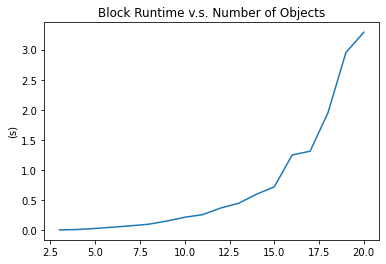

In [17]:
plt.plot(range(3, 21), avg_times)
plt.title('Block Runtime v.s. Number of Objects')
plt.ylabel('(s)')

Text(0.5, 1.0, 'Block Number of Variables v.s. Number of Objects')

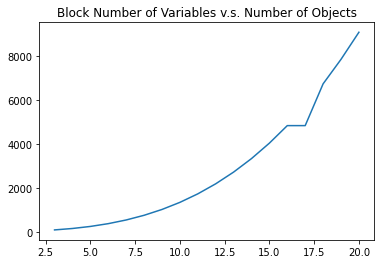

In [18]:
plt.plot(range(3, 21), num_variables)
plt.title('Block Number of Variables v.s. Number of Objects')

Text(0.5, 1.0, 'Block Number of Constraints v.s. Number of Objects')

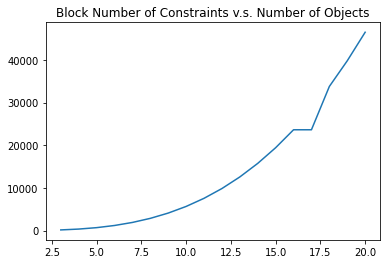

In [19]:
plt.plot(range(3, 21), num_constraints)
plt.title('Block Number of Constraints v.s. Number of Objects')

In [60]:
num_constraints

[138, 336, 670, 1176, 1890, 2848, 4086, 5640]

Text(0.5, 1.0, 'Clevr')

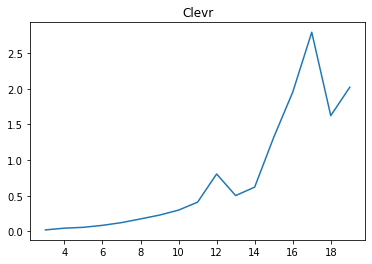

In [27]:
plt.plot(range(3, 20), avg_times)
plt.title('Clevr')

Text(0.5, 1.0, 'Clevr')

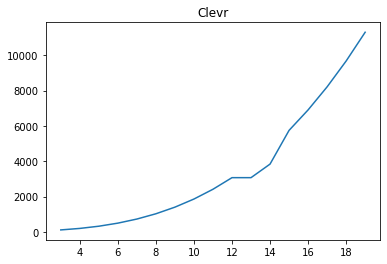

In [28]:
plt.plot(range(3, 20), num_variables)
plt.title('Clevr')

Text(0.5, 1.0, 'Clevr')

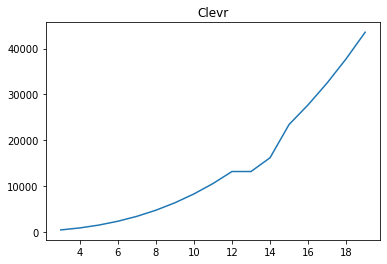

In [29]:
plt.plot(range(3, 20), num_constraints)
plt.title('Clevr')